In [159]:
%matplotlib widget
%load_ext autoreload
%autoreload 2

In [160]:
import nibabel as nib
import numpy as np
import torch as t
from scipy.ndimage import zoom
import torch.nn as nn
from pathlib import Path
import matplotlib.pyplot as plt
import pickle
from tqdm import tqdm
from DiagnosisAI.datasets_torch.brain_3d_dataset import Brain3DDataset
from DiagnosisAI.utils.metrics import calc_metrics, calculate_type_errors
from DiagnosisAI.models.Unet3D import Unet3d
from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
from DiagnosisAI.utils.utils_function import get_max_area_slice
from sklearn.neighbors import NearestNeighbors
from sklearn.model_selection import train_test_split
import pandas as pd
from torchmetrics import JaccardIndex
import matplotlib
import nipy
from nibabel.testing import data_path
import nibabel as nib
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pathlib
import pickle
import plotly.express as px


# 32, 32, 32 SIZE

In [2]:
logs = pd.read_csv('/mnt/e/mgr/trainings/logs/seg_binary_3d/resnet34_32_32_32/logs_best.csv')

In [3]:
logs.columns

Index(['Unnamed: 0', 'train_loss', 'val_loss', 'ji', 'val_ji', 'acc', 'prec',
       'f1', 'recall', 'val_acc', 'val_prec', 'val_f1', 'val_recall'],
      dtype='object')

In [4]:
logs.columns
metric_cols = ["acc", 'recall', 'prec', 'f1', 'val_recall', 'val_prec', 'val_acc', 'val_f1', 'ji', 'val_ji']
logs[metric_cols] = logs[metric_cols] * 100

In [5]:
log_train_loss = logs['train_loss']
log_val_loss = logs['val_loss']
epochs = np.arange(1, len(log_val_loss) + 1)

In [6]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 14}

matplotlib.rc('font', **font)

Text(0, 0.5, 'Wartość binarnej entropii krzyżowej')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


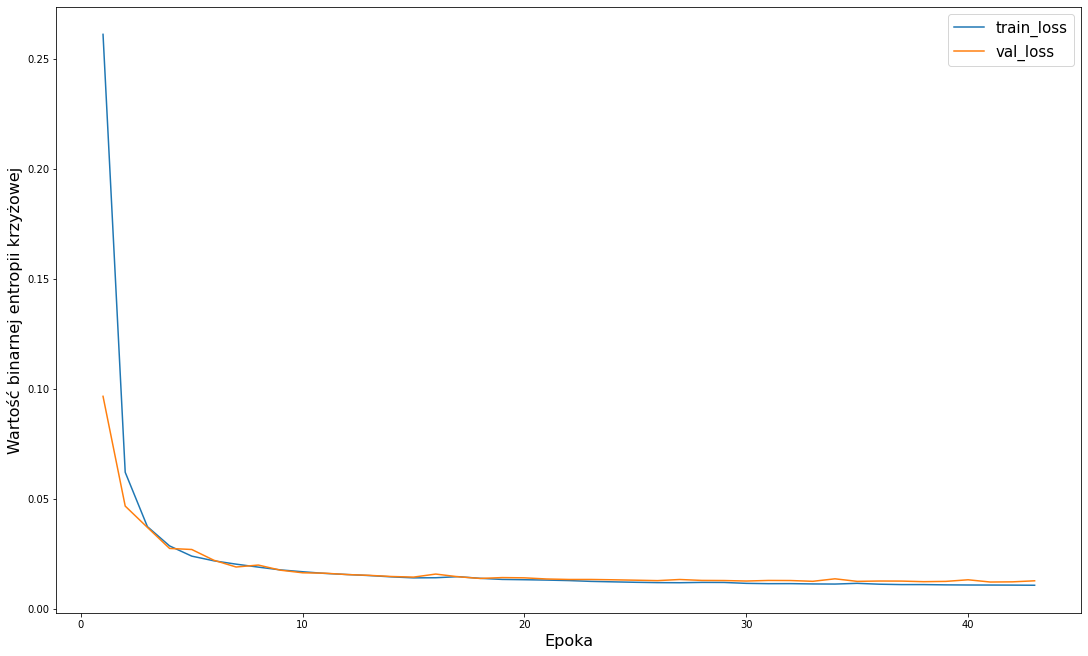

In [7]:
fig, ax = plt.subplots(figsize=(15, 9), constrained_layout=True)

ax.plot(epochs, log_train_loss)
ax.plot(epochs, log_val_loss)
ax.legend(["train_loss", "val_loss"], loc=0, prop={'size': 15})
ax.set_xlabel('Epoka', size=16)
ax.set_ylabel('Wartość binarnej entropii krzyżowej', size=16)

Text(0, 0.5, 'Wartość [%]')

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.
findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


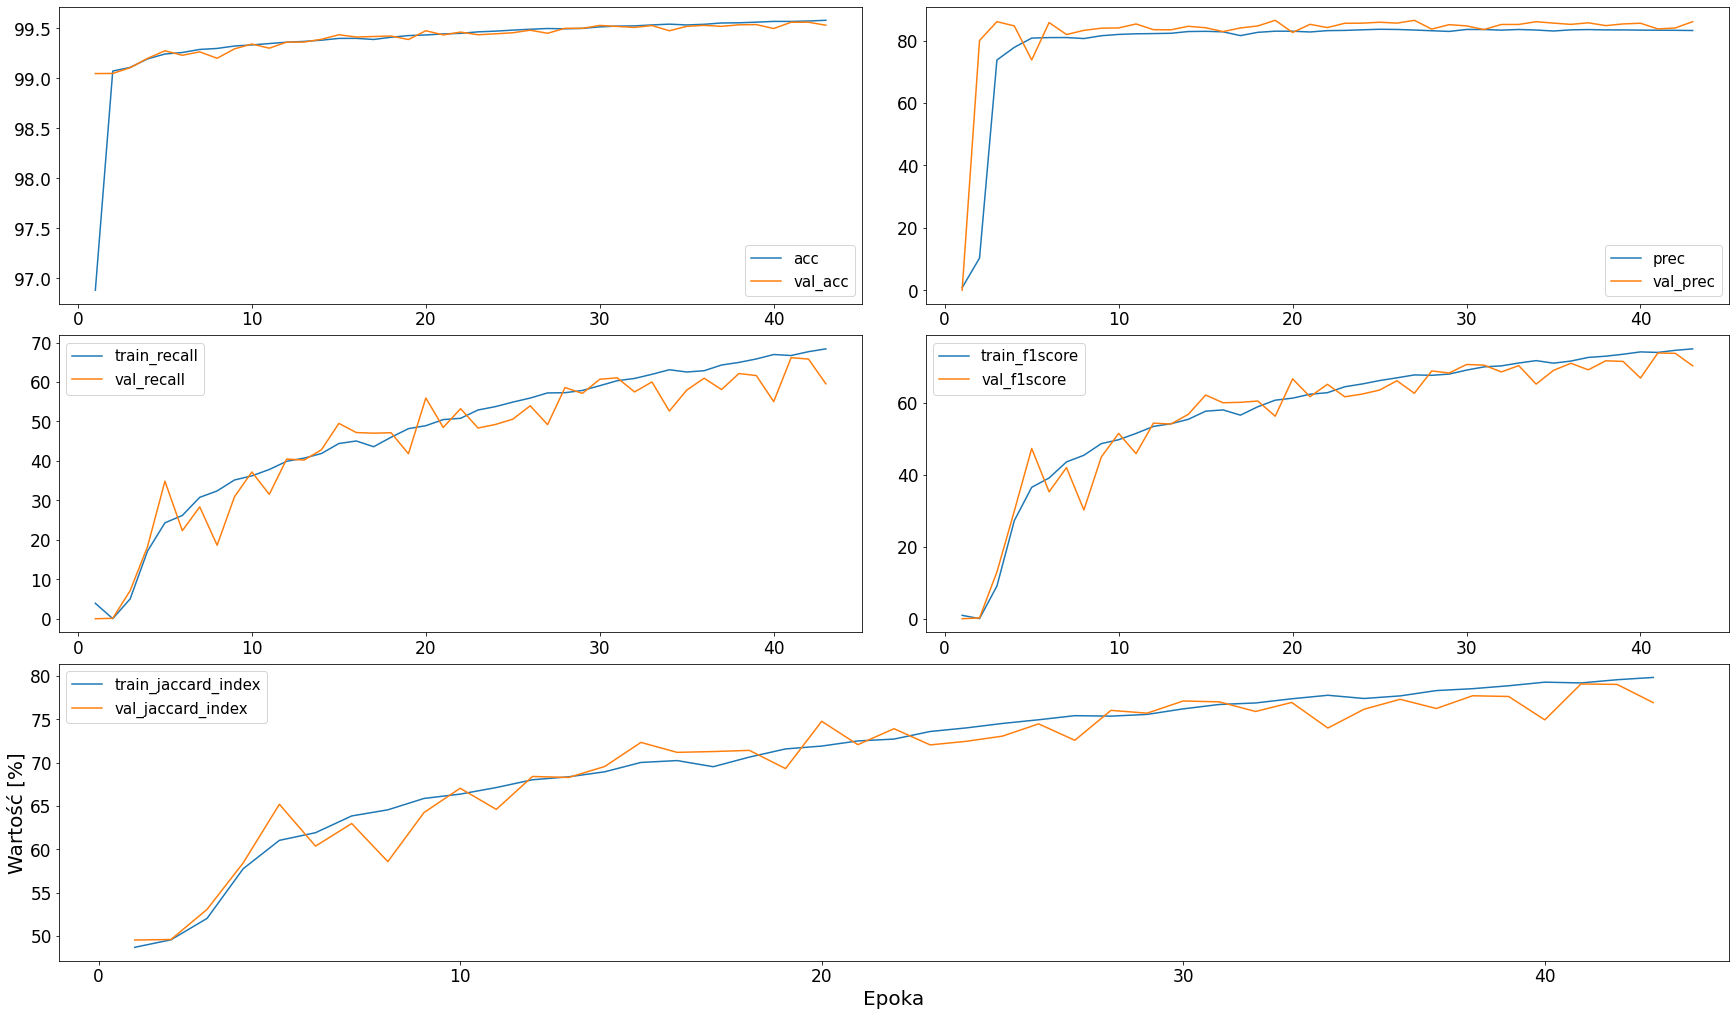

In [8]:
font = {'family' : 'normal',
        'weight' : 'normal',
        'size'   : 17}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(24, 14), constrained_layout=True)
spec = fig.add_gridspec(3, 2)
ax00 = fig.add_subplot(spec[0, 0])
ax01 = fig.add_subplot(spec[0, 1])
ax10 = fig.add_subplot(spec[1, 0], sharex=ax00)
ax11 = fig.add_subplot(spec[1, 1], sharex=ax01)
ax2 = fig.add_subplot(spec[2, :])
ax00.plot(epochs, logs['acc'])
ax00.plot(epochs, logs['val_acc'])
ax00.legend(['acc', 'val_acc'], loc=0, prop={'size': 15})
ax01.plot(epochs, logs['prec'])
ax01.plot(epochs, logs['val_prec'])
ax01.legend(['prec', 'val_prec'], loc=0, prop={'size': 15})
ax10.plot(epochs, logs['recall'])
ax10.plot(epochs, logs['val_recall'])
ax10.legend(['train_recall', 'val_recall'], loc=0, prop={'size': 15})
ax11.plot(epochs, logs['f1'])
ax11.plot(epochs, logs['val_f1'])
ax11.legend(['train_f1score', 'val_f1score'], loc=0, prop={'size': 15})
ax2.plot(epochs, logs['ji'])
ax2.plot(epochs, logs['val_ji'])
ax2.legend(['train_jaccard_index', 'val_jaccard_index'], loc=0, prop={'size': 15})
ax2.set_xlabel('Epoka', size=20)
ax2.set_ylabel('Wartość [%]', size=20)

In [2]:
batch_size = 1
num_workers = 4
train_size = 0.7
seed = 42
device = t.device('cuda')
dataset_root_path = "../datasets/brain/Brats2021_training_df/"

In [3]:
def __get_filenames_from_dir__(path:str):
    filenames = []
    for dir in Path(path).iterdir():
        filenames.append(dir)
    return filenames

test_size = 1 - train_size
filenames = __get_filenames_from_dir__(dataset_root_path)
train_names, val_names = train_test_split(filenames, test_size=test_size, random_state=seed)
val_names, test_names = train_test_split(val_names, test_size=0.5, random_state=seed)

# ======== LOAD DATA ===========
print("Loading datasets")
train_dataset = Brain3DDataset(train_names, scale=32)
val_dataset = Brain3DDataset(val_names, scale=32)
test_dataset = Brain3DDataset(test_names, scale=32)

train_loader = t.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=num_workers)
val_loader = t.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=num_workers)
test_loader = t.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=num_workers)

img, label = next(iter(train_loader))
print("Shapes:")
print(f"Input img: {img.shape},  Label: {label.shape}")

Loading datasets
Shapes:
Input img: torch.Size([1, 4, 32, 32, 32]),  Label: torch.Size([1, 1, 32, 32, 32])


In [4]:
network = Unet3d(in_channels=4, out_channels=1).to(device)

In [5]:
network.load_state_dict(t.load('/mnt/e/mgr/trainings/model_states/seg_binary_3d/resnet34_32_32_32/model_state_best'))

<All keys matched successfully>

### WIZUALIZACJA 3D

In [6]:
random_cases = np.random.randint(0, len(test_dataset), 10)

In [22]:
predicted_masks = []
gt_masks = []
scan = []
network.eval()
for idx in random_cases:
    img, label = test_dataset[idx]
    img = img.cuda()
    label = label.cuda()
    with t.no_grad():
        output = network(img.unsqueeze(0))
        output = nn.Sigmoid()(output)
        output = t.where(output >= 0.4, 1, output)
        scan.append(img)
        predicted_masks.append(output)
        gt_masks.append(label)

In [162]:
def plot_scan(i_slice, ax, sampling: int = 1):
    slice = i_slice
    mask = (slice > 0).nonzero()
    x, y, z = mask
    y = y[::sampling]
    x = x[::sampling]
    z = z[::sampling]
    colors = slice[x, y, z]

    # ax.scatter(x, y, z, c='purple', alpha=0.2, s=25.0)
    
    return x, y, z

def plot_segments(seg, ax,
                        colors: list = ['yellow', 'green'],
                        sampling: list = [1, 1, 1],
                        sizes: list = [30.0, 30.0, 30.0]):
    
    segments = seg

    segments_info = {0:{"color": colors[0], "class_idx": 1, "name": 'core', "sampling":sampling[0], "size": sizes[0], "alpha": 1.0}}

    for seg in segments_info:
        seg_info = segments_info[seg]
        seg_mask = (segments == seg_info['class_idx']).nonzero()
        seg_x, seg_y, seg_z = seg_mask
        seg_x = seg_x[::seg_info['sampling']]
        seg_y = seg_y[::seg_info['sampling']]
        seg_z = seg_z[::seg_info['sampling']]

        # ax.scatter(seg_x, seg_y, seg_z, c=seg_info['color'], alpha=seg_info['alpha'], linewidth=seg_info['size'], label=seg_info['name'])
        return seg_x, seg_y, seg_z


/tmp/ipykernel_264/833325462.py:2: MatplotlibDeprecationWarning:

Calling gca() with keyword arguments was deprecated in Matplotlib 3.4. Starting two minor releases later, gca() will take no keyword arguments. The gca() function should only be used to get the current axes, or if no axes exist, create new axes with default keyword arguments. To create a new axes with non-default arguments, use plt.axes() or plt.subplot().



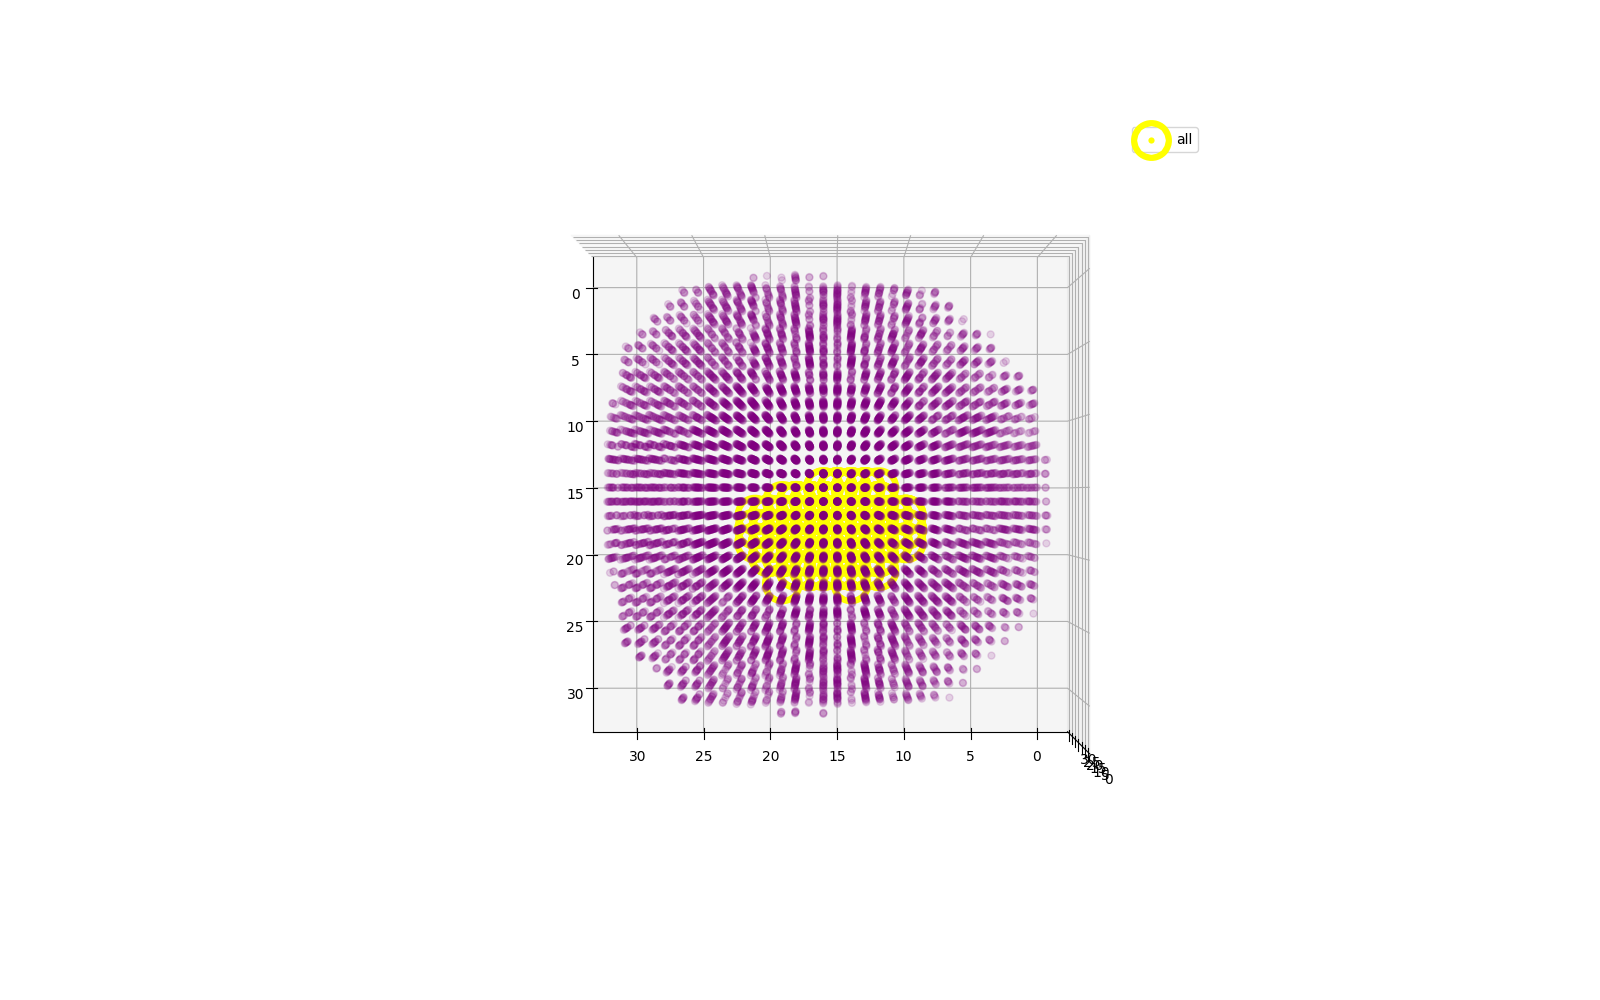

In [180]:
fig = plt.figure(figsize=(16,10))
ax = fig.gca(projection='3d')

ii = gt_masks[0][0].cpu().numpy()
ii_img = scan[0][0].cpu().numpy()

x, y, z = plot_scan(ii_img, ax)
seg_x, seg_y, seg_z = plot_segments(ii, ax, sampling=[1, 30, 30])

ax.scatter(x, y, z, c='purple', alpha=0.15, s=25.0)
ax.scatter(seg_x, seg_y, seg_z, c='yellow', alpha=1.0, linewidth=25.0, label='all')
ax.legend()
ax.view_init(elev=270., azim=180)

In [13]:
global_tp = 0.0
global_fp = 0.0
global_tn = 0.0
global_fn = 0.0
global_ji = 0.0

network.eval()
for i, (img, label) in enumerate(tqdm(test_loader)):
    img = img.to(device)
    label = label.to(device)
    with t.no_grad():
        output = network(img)
    output = nn.Sigmoid()(output)
    output = t.where(output >= 0.4, 1, output)
   
    tp, fp, tn, fn = calculate_type_errors(output.cpu(), label.cpu(), mode='segment_binary')
    ji = JaccardIndex(num_classes=2)(output.cpu(), label.type(t.int32).cpu()).item()
    
    global_ji += ji
    global_tp += tp
    global_fp += fp
    global_tn += tn
    global_fn += fn

recall, precision, acc, f1_score = calc_metrics(global_tp, global_fp, global_tn, global_fn)
print(f"Acc: {acc}, Recall: {recall}, F1score: {f1_score}, Precision: {precision}, IoU: {global_ji / (i+1)}")

100%|██████████| 188/188 [03:58<00:00,  1.27s/it]

Acc: 0.9963135123252869, Recall: 0.837408185005188, F1score: 0.8014270067214966, Precision: 0.7684104442596436, IoU: 0.8135288820621815


In [16]:
print(f"Acc: {acc*100}, Recall: {recall*100}, F1score: {f1_score*100}, Precision: {precision*100}, IoU: {100*(global_ji / (i+1))}")

Acc: 99.63134765625, Recall: 83.7408218383789, F1score: 80.1427001953125, Precision: 76.8410415649414, IoU: 81.35288820621815


In [7]:
eval_network = network.enc.cpu()
eval_network.eval()

Encoder(
  (conv1): Conv3d(4, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
  (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool3d(kernel_size=3, stride=(2, 2, 2), padding=1, dilation=1, ceil_mode=False)
  (layer0): Sequential(
    (0): Conv3d(4, 64, kernel_size=(7, 7, 7), stride=(2, 2, 2), padding=(3, 3, 3), bias=False)
    (1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
  )
  (layer1): Sequential(
    (0): MaxPool3d(kernel_size=3, stride=(2, 2, 2), padding=1, dilation=1, ceil_mode=False)
    (1): Sequential(
      (0): BasicBlock(
        (conv1): Conv3d(64, 64, kernel_size=(3, 3, 3), stride=(1, 1, 1), padding=(1, 1, 1), bias=False)
        (bn1): BatchNorm3d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv3d(64, 64, kernel_size=(3

In [17]:
embeddings = []
t1ce_images = []
labels = []
for i, (img, label) in enumerate(tqdm(test_dataset)):
    with t.no_grad():
        output = eval_network(img.unsqueeze(0))
        output = output[-1]
        output = nn.AdaptiveAvgPool2d(output_size=(1, 1))(output)
        output = output.squeeze().numpy()
        output = output.reshape(1, -1)

    embeddings.append(output)
    t1ce_images.append(img[3].numpy())
    labels.append(label.numpy())

    del output

embeddings = np.array(embeddings)

100%|██████████| 188/188 [11:14<00:00,  3.59s/it]


In [9]:
embeddings = embeddings.squeeze()

NameError: name 'embeddings' is not defined

In [32]:
with open("/mnt/e/mgr/embeddings/extracted_features_brats_3d_323232.pickle", "rb") as handle:
    embeddings = pickle.load(handle)

/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:795: FutureWarning: The default initialization in TSNE will change from 'random' to 'pca' in 1.2.
  warnings.warn(
/home/michalheit/miniconda3/envs/mgr_dp/lib/python3.9/site-packages/sklearn/manifold/_t_sne.py:805: FutureWarning: The default learning rate in TSNE will change from 200.0 to 'auto' in 1.2.
  warnings.warn(


[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 188 samples in 0.001s...
[t-SNE] Computed neighbors for 188 samples in 0.061s...
[t-SNE] Computed conditional probabilities for sample 188 / 188
[t-SNE] Mean sigma: 1.431034
[t-SNE] KL divergence after 250 iterations with early exaggeration: 52.433655
[t-SNE] KL divergence after 1000 iterations: 0.130806


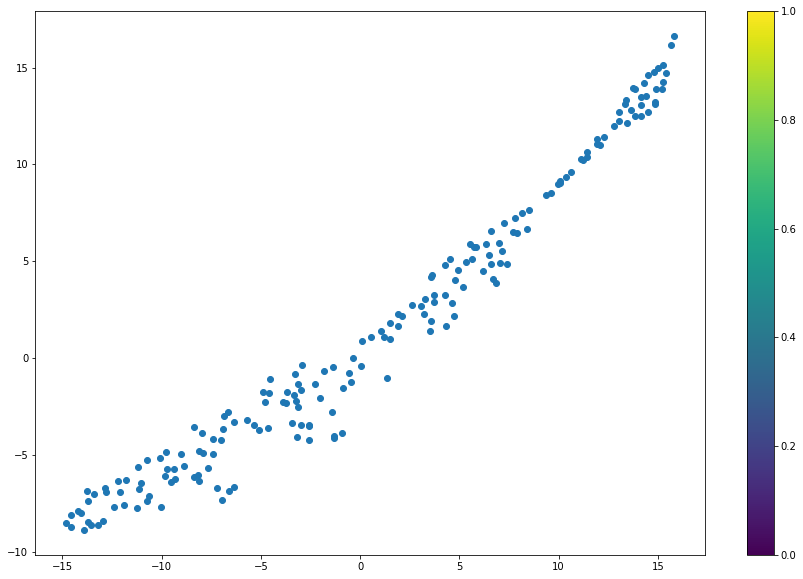

In [11]:
tsne_results = TSNE(n_components=2,verbose=1,metric='euclidean', random_state=42).fit_transform(embeddings)
plt.figure(figsize=(15, 10))
plt.scatter(tsne_results[:,0],tsne_results[:,1], cmap=plt.cm.get_cmap('coolwarm'))
plt.colorbar()

embeddings
test_names same idx as embeddings

In [12]:
def find_case(case_folder: str):
    sample = None
    seg = None
    for filename_path in case_folder.iterdir():
        if 't1ce' in filename_path.name:
            sample = nib.load(filename_path).get_fdata().copy()
        if 'seg' in filename_path.name:
            seg = nib.load(filename_path).get_fdata().copy()
            seg = np.where(seg >= 1, 1, 0)

    return sample, seg

In [28]:
neighbors = NearestNeighbors(n_neighbors=len(embeddings), algorithm='brute', metric='euclidean').fit(embeddings)
distances, indices = neighbors.kneighbors([embeddings[180]])
indices = indices.flatten()

k_nearest = indices[0:5]
nearest_dist = distances.flatten()[0:5]
k_furthest = indices[-5:][::-1]
furthest_dist = distances.flatten()[-5:][::-1]

In [29]:
simillar_images = [find_case(test_names[idx]) for idx in k_nearest]
no_simillar_images = [find_case(test_names[idx]) for idx in k_furthest]
simillar_max_slice = [get_max_area_slice(find_case(test_names[idx])[1]) for idx in k_nearest]
no_simillar_max_slice = [get_max_area_slice(find_case(test_names[idx])[1]) for idx in k_furthest]

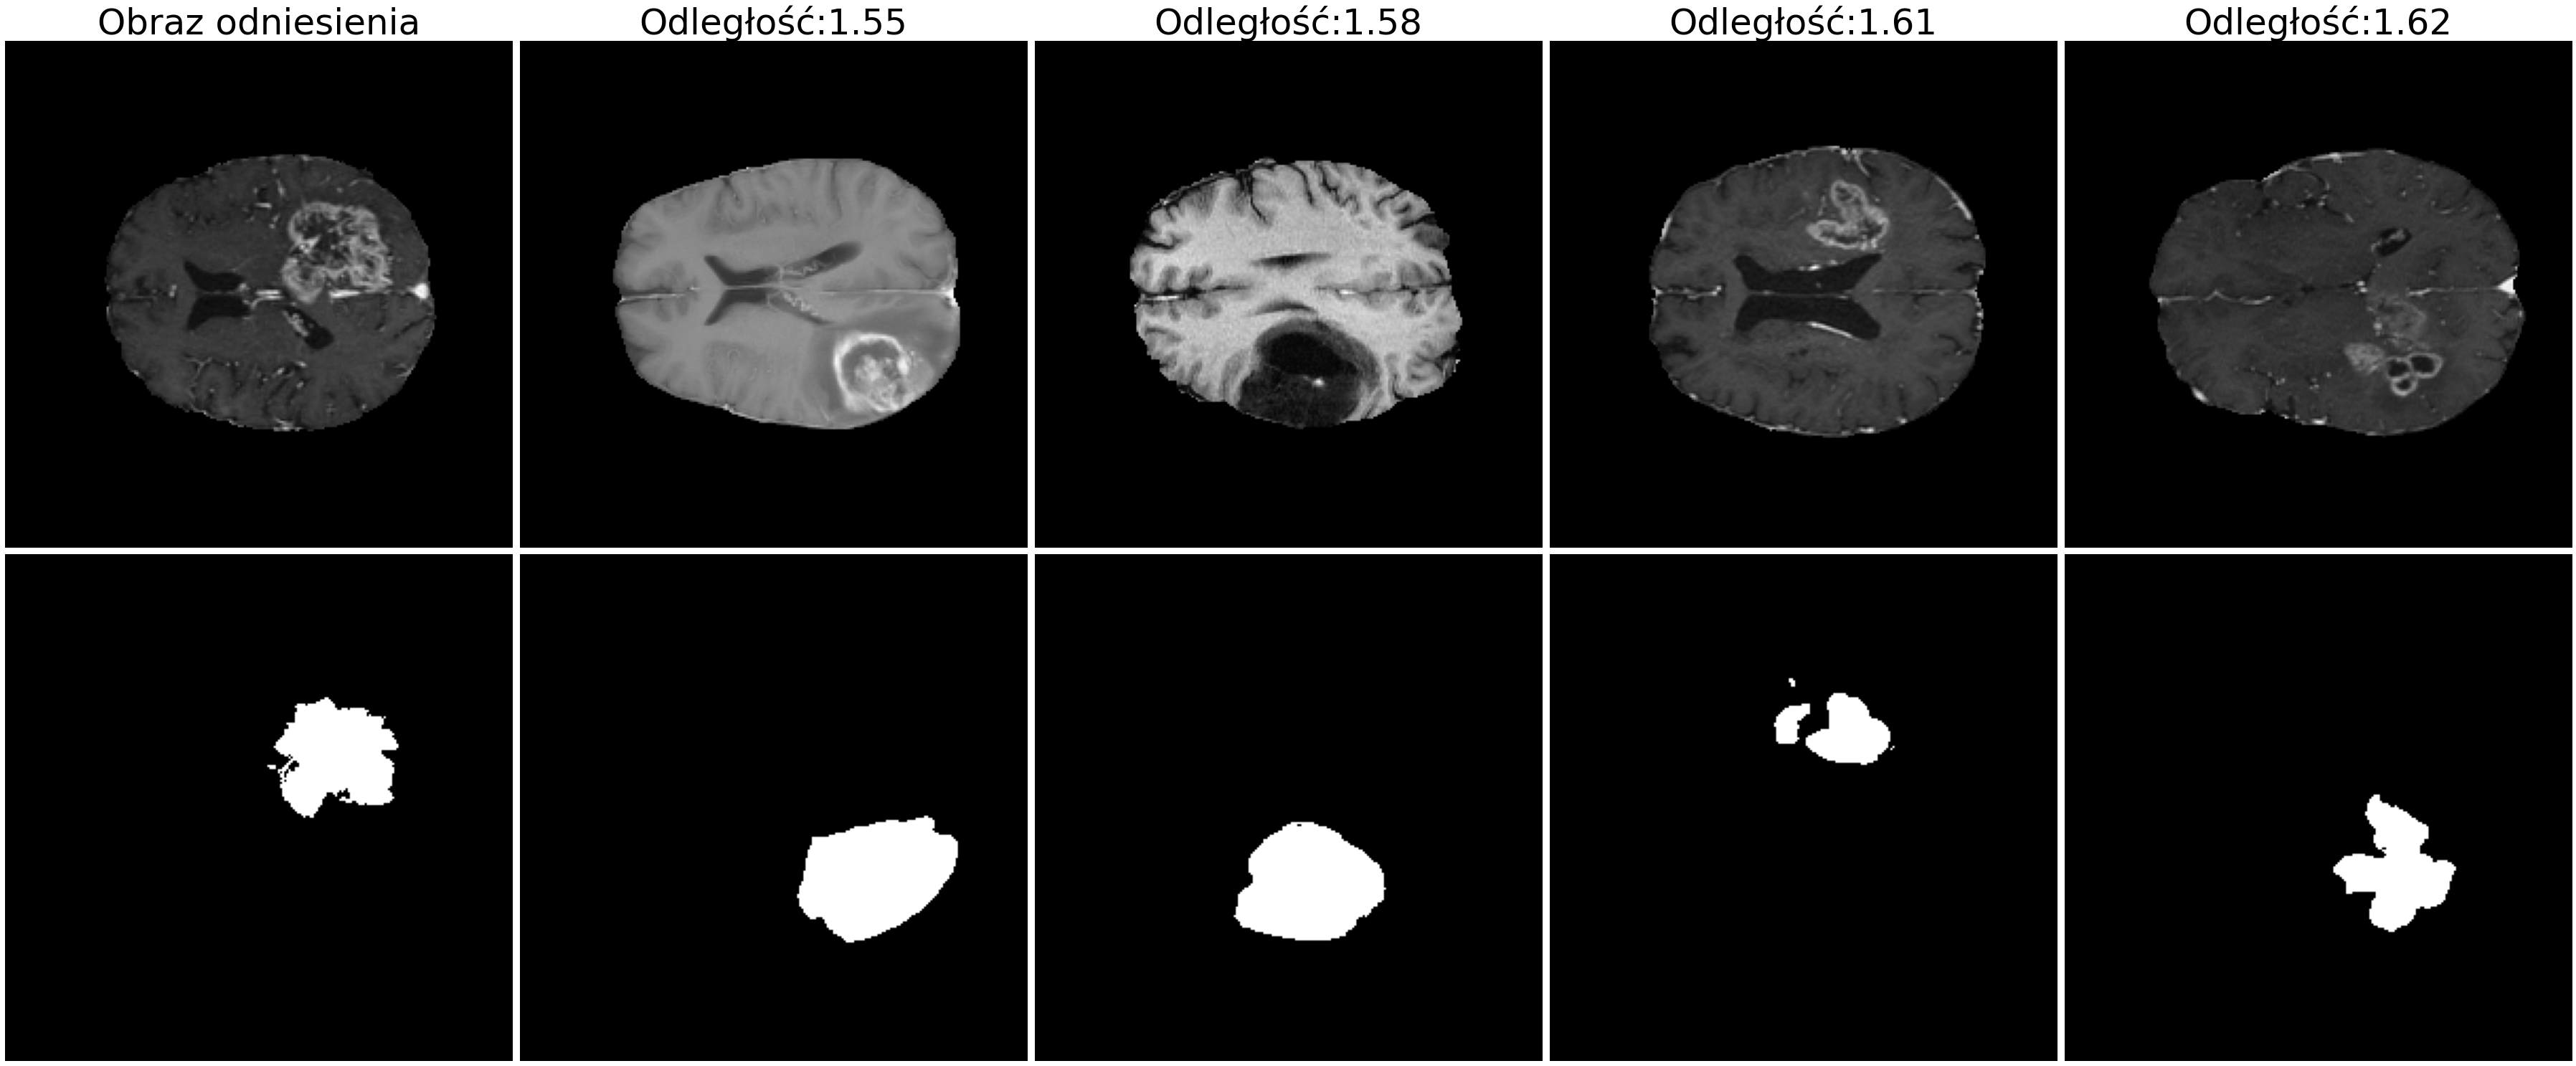

In [30]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 21))
for i, idx in enumerate(k_nearest):
    ax[0, i].imshow(simillar_images[i][0][:, :, simillar_max_slice[i]], cmap='gray')
    ax[1, i].imshow(simillar_images[i][1][:, :, simillar_max_slice[i]], cmap='gray')
    ax[0, i].set_title(f'Odległość:{round(nearest_dist.tolist()[i], 2)}', size=50)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
ax[0, 0].set_title('Obraz odniesienia', size=50)
fig.tight_layout()

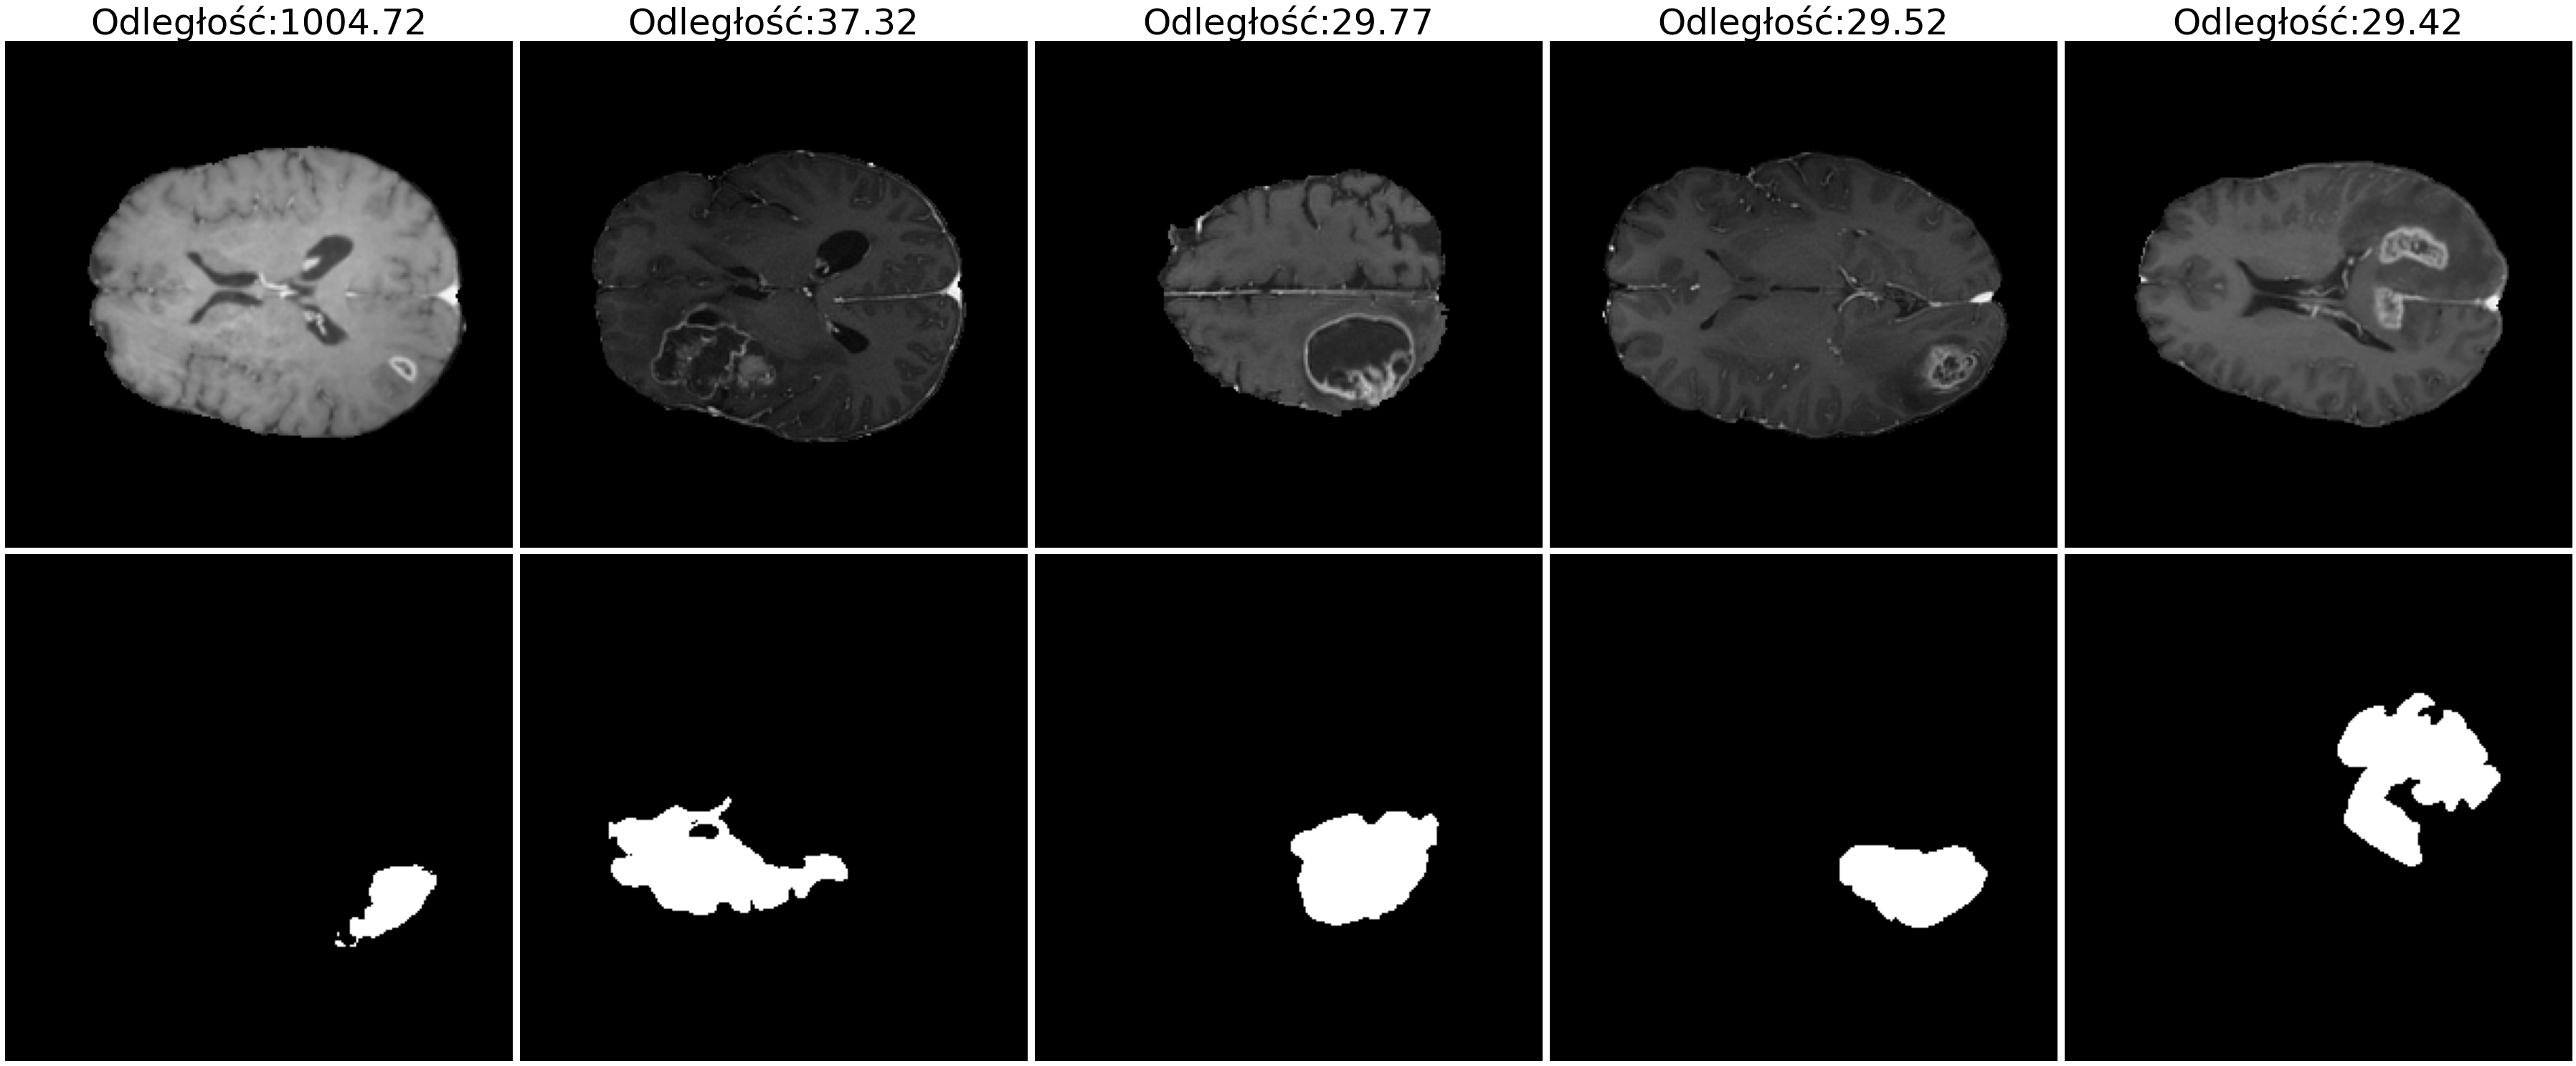

In [31]:
fig, ax = plt.subplots(nrows=2, ncols=5, figsize=(50, 21))
for i, idx in enumerate(k_furthest):
    ax[0, i].imshow(no_simillar_images[i][0][:, :, no_simillar_max_slice[i]], cmap='gray')
    ax[1, i].imshow(no_simillar_images[i][1][:, :, no_simillar_max_slice[i]], cmap='gray')
    ax[0, i].set_title(f'Odległość:{round(furthest_dist.tolist()[i], 2)}', size=50)
    ax[0, i].axis('off')
    ax[1, i].axis('off')
fig.tight_layout()